In [41]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pymod6
import pymod6.input as mod_input

In [42]:
base_case = mod_input.merge_case_parts(
    mod_input.basecases.BASE_0,
    mod_input.basecases.SPECTRAL_VNIR,
    mod_input.make_case(
        SPECTRAL__LBMNAM="T",
        SPECTRAL__BMNAME="01_2013",
        # ATMOSPHERE__H2OUNIT="a",  # units of atm-cm
         ATMOSPHERE__H2OUNIT=" ",  # scale
        ATMOSPHERE__O3UNIT="g",   # units og g/cm^2
        # ATMOSPHERE__O3UNIT=" ",   # scale
    ),
    allow_override=True,
)

sweep_1_keyword = "ATMOSPHERE__H2OSTR"
# sweep_1_range = (1, 4)  # cm-atm
sweep_1_range = (0.5, 2)  # scale
sweep_2_keyword = "ATMOSPHERE__O3STR"
sweep_2_range = (0.25, 0.45) # g/cm^2 
# sweep_2_range = (0.25, 0.45) # scale

sweep_1_values = np.linspace(*sweep_1_range, 4)
sweep_2_values = np.linspace(*sweep_2_range, 4)

input_files = []

for swp_1 in sweep_1_values:
    builder = mod_input.ModtranInputBuilder()
    base_template = builder.add_template_case(base_case, **{sweep_1_keyword: swp_1, sweep_2_keyword: sweep_2_values[0]})
    for swp_2 in sweep_2_values[1:]:
        base_template.extend(**{sweep_2_keyword: swp_2})
    input_files.append(builder.build_json_input(output_legacy=True, binary=True, output_sli=True))

In [43]:
mod_env = pymod6.ModtranEnv.from_shell_file(
    pathlib.Path("~/MIT-LL/MODTRAN/setup_env.sh").expanduser()
)
mod_exec = pymod6.ModtranExecutable(env=mod_env)

In [44]:
results = mod_exec.run_parallel(input_files)

In [45]:
tape7_data = xr.concat(
    [
        xr.concat(
            [
                pymod6.io.read_sli(swp_2_case.sli_header)
                for swp_2_case in swp_1_results.cases_output_files
            ],
            dim=sweep_2_keyword
        ).assign_coords({sweep_2_keyword: sweep_2_values})
        for swp_1_results in results
    ],
    dim=sweep_1_keyword,
).assign_coords({sweep_1_keyword: sweep_1_values})
display(tape7_data)

<xarray.Dataset>
Dimensions:                       (ATMOSPHERE__H2OSTR: 4, ATMOSPHERE__O3STR: 4,
                                   wavelength: 17866)
Coordinates:
  * wavelength                    (wavelength) float64 7.14e+03 ... 2.5e+04
  * ATMOSPHERE__O3STR             (ATMOSPHERE__O3STR) float64 0.25 ... 0.45
  * ATMOSPHERE__H2OSTR            (ATMOSPHERE__H2OSTR) float64 0.5 1.0 1.5 2.0
Data variables: (12/15)
    total transmittance           (ATMOSPHERE__H2OSTR, ATMOSPHERE__O3STR, wavelength) float32 ...
    path emission                 (ATMOSPHERE__H2OSTR, ATMOSPHERE__O3STR, wavelength) float32 ...
    path thermal scat             (ATMOSPHERE__H2OSTR, ATMOSPHERE__O3STR, wavelength) float32 ...
    surface emission              (ATMOSPHERE__H2OSTR, ATMOSPHERE__O3STR, wavelength) float32 ...
    path multiple scat            (ATMOSPHERE__H2OSTR, ATMOSPHERE__O3STR, wavelength) float32 ...
    path single scat              (ATMOSPHERE__H2OSTR, ATMOSPHERE__O3STR, wavelength) float32 ...
    ...                            ...
    reference irradiance          (ATMOSPHERE__H2OSTR, ATMOSPHERE__O3STR, wavelength) float32 ...
    irradiance at observer        (ATMOSPHERE__H2OSTR, ATMOSPHERE__O3STR, wavelength) float32 ...
    - nat log path trans          (ATMOSPHERE__H2OSTR, ATMOSPHERE__O3STR, wavelength) float32 ...
    directional emissivity        (ATMOSPHERE__H2OSTR, ATMOSPHERE__O3STR, wavelength) float32 ...
    top-of-atmosphere irradiance  (ATMOSPHERE__H2OSTR, ATMOSPHERE__O3STR, wavelength) float32 ...
    brightness temp               (ATMOSPHERE__H2OSTR, ATMOSPHERE__O3STR, wavelength) float32 ...
Attributes:
    description:        MODTRAN radiance spectra.
    samples:            17866
    lines:              15
    bands:              1
    header offset:      0
    file type:          ENVI Spectral Library
    data type:          4
    interleave:         bsq
    byte order:         0
    wavelength units:   Wavenumbers
    data ignore value:  NaN

In [46]:
assert tape7_data.attrs["wavelength units"] == "Wavenumbers"
wavelengths = pymod6.unit.Wavenumber(tape7_data.wavelength, "cm-1").as_wavelength("um")

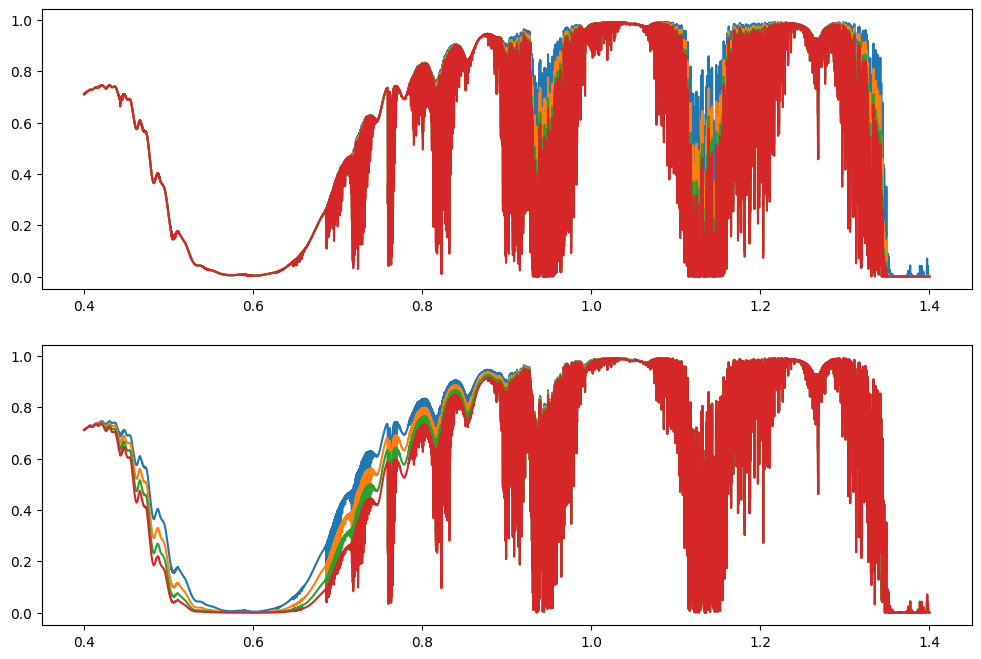

In [47]:
fig, axs = plt.subplots(nrows=2, figsize=(12, 8))

for swp_1_idx in range(len(sweep_2_values)):
    axs[0].plot(wavelengths, tape7_data["total transmittance"][swp_1_idx, 0])

for swp_2_idx in range(len(sweep_2_values)):
    axs[1].plot(wavelengths, tape7_data["total transmittance"][0, swp_2_idx])